# Анализ статистик гессианов

Этот ноутбук анализирует сохраненные гессианы из экспериментов exp15:
- Начальные гессианы (до обучения)
- Гессианы после обучения

## Анализируемые статистики:
1. **Сингулярные числа** - их среднее и дисперсия
2. **Коммутатор матриц** среднего гессиана и среднего квадрата гессиана
3. **Флуктуации собственных значений** гессиана

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy.linalg import svd, eigvals
import pandas as pd
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Пути к данным
DATA_DIR = Path("../../data/checkpoints/exp15")
INITIAL_HESSIANS_PATH = DATA_DIR / "initial_hessians.pkl"
TRAINED_HESSIANS_PATH = DATA_DIR / "trained_hessians.pkl"

## 1. Загрузка данных

In [2]:
# Загрузка гессианов
with open(INITIAL_HESSIANS_PATH, 'rb') as f:
    initial_hessians = pickle.load(f)

with open(TRAINED_HESSIANS_PATH, 'rb') as f:
    trained_hessians = pickle.load(f)

print("Загружены гессианы:")
print(f"Начальные: {list(initial_hessians.keys())} batch sizes")
print(f"После обучения: {list(trained_hessians.keys())} batch sizes")

# Проверим размеры
for batch_size in initial_hessians.keys():
    n_initial = len(initial_hessians[batch_size])
    n_trained = len(trained_hessians[batch_size])
    shape = initial_hessians[batch_size][0].shape if n_initial > 0 else "N/A"
    print(f"Batch {batch_size}: {n_initial} начальных, {n_trained} обученных, размер: {shape}")

Загружены гессианы:
Начальные: [1, 4, 8, 16, 32, 64] batch sizes
После обучения: [1, 4, 8, 16, 32, 64] batch sizes
Batch 1: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 4: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 8: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 16: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 32: 1000 начальных, 1000 обученных, размер: (386, 386)
Batch 64: 1000 начальных, 1000 обученных, размер: (386, 386)


## 2. Анализ сингулярных чисел

In [3]:
# %% [markdown]
# ## 2. Функции для статистики

# %%
def get_singular_stats(hessians):
    """Вычисляет среднее и дисперсию сингулярных чисел"""
    stats = []
    for h in hessians:
        s = svd(h, compute_uv=False)
        stats.append({
            'mean': np.mean(s),
            'std': np.std(s),
            'max': np.max(s),
            'min': np.min(s),
        })
    return pd.DataFrame(stats)

def commutator(A, B):
    """[A, B] = AB - BA"""
    return A @ B - B @ A

def frobenius_norm_squared(M):
    return np.sum(M ** 2)

def get_commutator_stats(hessians):
    """Считает норму коммутатора между средним гессианом и средним квадратом"""
    hs = np.stack(hessians)
    H = np.mean(hs, axis=0)
    H2 = np.mean(hs @ hs, axis=0)
    comm = commutator(H, H2)
    return frobenius_norm_squared(comm)

def eigenvalue_fluctuations(hessians):
    """Вычисляет флуктуации спектра"""
    results = []
    for h in hessians:
        eigs = eigvals(h)
        eigs = np.real(eigs)  # убрать мнимые части (на всякий)
        results.append({
            'mean': np.mean(eigs),
            'std': np.std(eigs),
            'min': np.min(eigs),
            'max': np.max(eigs),
            'num_negative': np.sum(eigs < 0),
            'total': len(eigs),
        })
    return pd.DataFrame(results)

# %% [markdown]
# ## 3. Подсчёт статистик по всем batch_size

# %%
batch_stats = []

for batch_size in sorted(initial_hessians.keys()):
    init_hess = initial_hessians[batch_size]
    train_hess = trained_hessians[batch_size]

    # Сингулярные числа
    init_svd = get_singular_stats(init_hess)
    train_svd = get_singular_stats(train_hess)

    # Коммутаторы
    init_comm_norm = get_commutator_stats(init_hess)
    train_comm_norm = get_commutator_stats(train_hess)

    # Спектры
    init_eig = eigenvalue_fluctuations(init_hess)
    train_eig = eigenvalue_fluctuations(train_hess)

    batch_stats.append({
        'batch_size': batch_size,
        'init_svd_mean': init_svd['mean'].mean(),
        'init_svd_std': init_svd['std'].mean(),
        'train_svd_mean': train_svd['mean'].mean(),
        'train_svd_std': train_svd['std'].mean(),
        'init_comm_norm': init_comm_norm,
        'train_comm_norm': train_comm_norm,
        'init_eig_std': init_eig['std'].mean(),
        'train_eig_std': train_eig['std'].mean(),
        'init_neg_frac': init_eig['num_negative'].sum() / init_eig['total'].sum(),
        'train_neg_frac': train_eig['num_negative'].sum() / train_eig['total'].sum(),
    })

summary_df = pd.DataFrame(batch_stats)

# %%
summary_df.set_index('batch_size')


,init_svd_mean,init_svd_std,train_svd_mean,train_svd_std,init_comm_norm,train_comm_norm,init_eig_std,train_eig_std,init_neg_frac,train_neg_frac
batch_size,,,,,,,,,,
1,0.033364,0.221200,0.057346,0.716634,0.545219,1099.019775,0.223673,0.717464,0.130966,0.234280
4,0.026962,0.114379,0.056699,0.528675,0.037696,89.272057,0.117468,0.529626,0.180870,0.296150
8,0.023377,0.083300,0.056027,0.449877,0.008893,26.837683,0.086442,0.450764,0.210474,0.315028
16,0.020113,0.063073,0.053602,0.383008,0.002200,6.109187,0.066080,0.383776,0.237145,0.306034
32,0.017410,0.050767,0.052775,0.350722,0.000579,1.481649,0.053504,0.351337,0.218749,0.216003
64,0.015389,0.043113,0.051371,0.329394,0.000140,0.352234,0.045576,0.329835,0.225674,0.177098


## 4. Графики

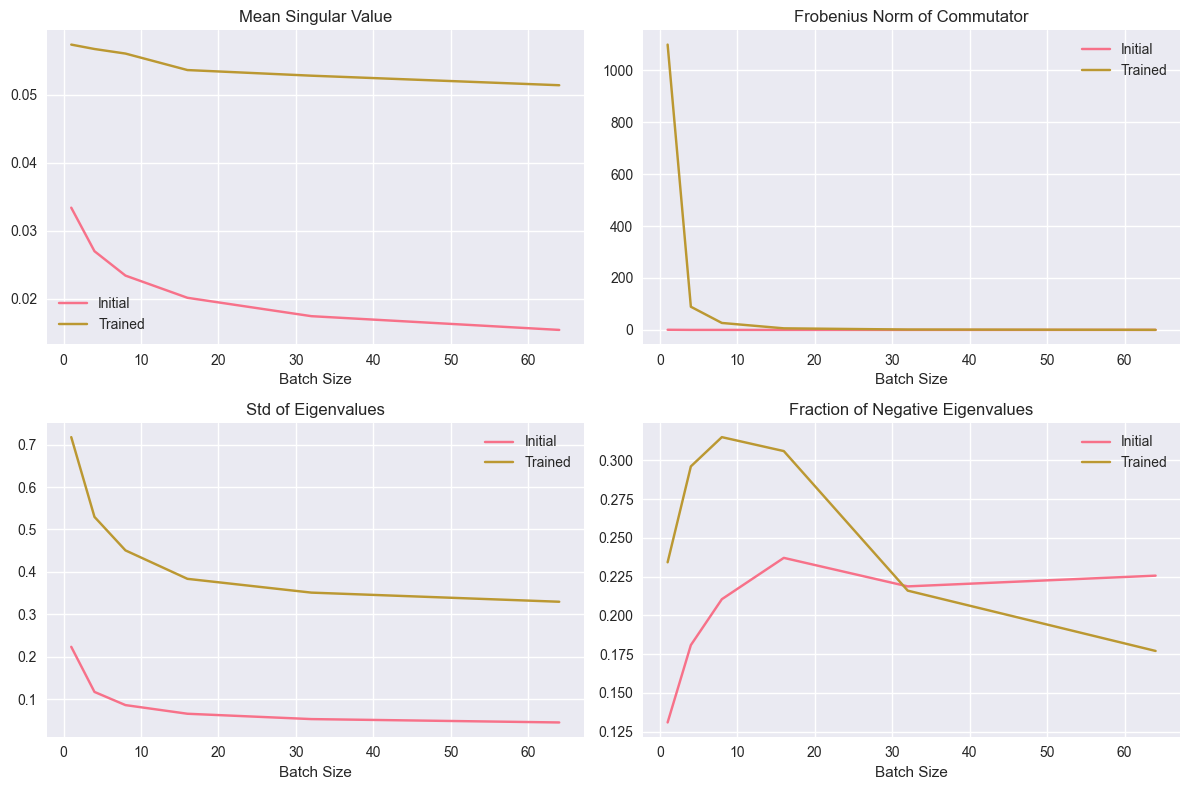

In [6]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(summary_df['batch_size'], summary_df['init_svd_mean'], label='Initial')
axes[0, 0].plot(summary_df['batch_size'], summary_df['train_svd_mean'], label='Trained')
axes[0, 0].set_title('Mean Singular Value')
axes[0, 0].set_xlabel('Batch Size')
axes[0, 0].legend()

axes[0, 1].plot(summary_df['batch_size'], summary_df['init_comm_norm'], label='Initial')
axes[0, 1].plot(summary_df['batch_size'], summary_df['train_comm_norm'], label='Trained')
axes[0, 1].set_title('Frobenius Norm of Commutator')
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].legend()

axes[1, 0].plot(summary_df['batch_size'], summary_df['init_eig_std'], label='Initial')
axes[1, 0].plot(summary_df['batch_size'], summary_df['train_eig_std'], label='Trained')
axes[1, 0].set_title('Std of Eigenvalues')
axes[1, 0].set_xlabel('Batch Size')
axes[1, 0].legend()

axes[1, 1].plot(summary_df['batch_size'], summary_df['init_neg_frac'], label='Initial')
axes[1, 1].plot(summary_df['batch_size'], summary_df['train_neg_frac'], label='Trained')
axes[1, 1].set_title('Fraction of Negative Eigenvalues')
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 5. Подробные графики: сингулярные и собственные значения


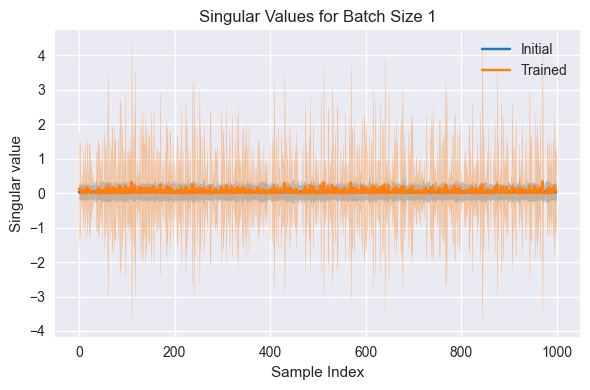

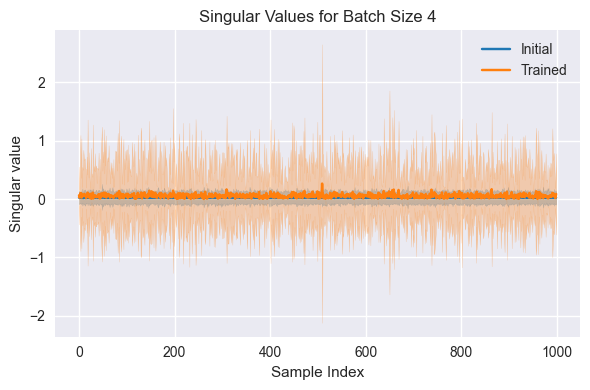

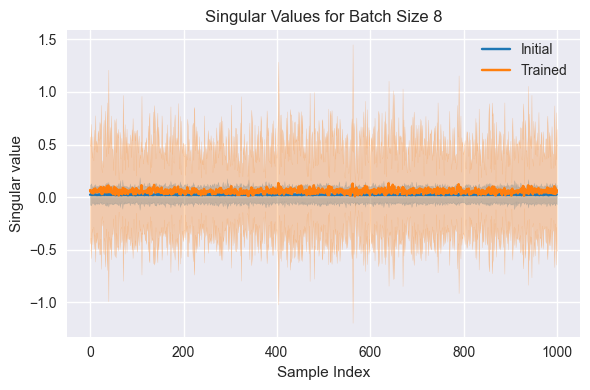

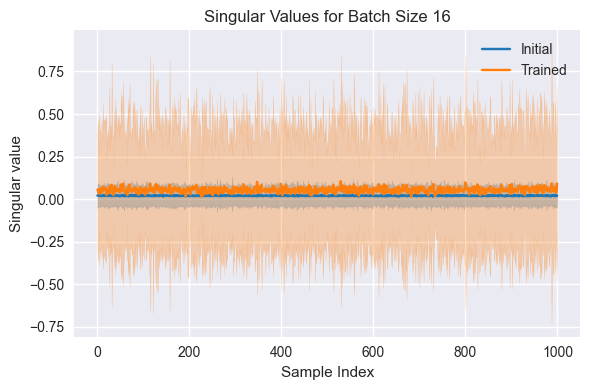

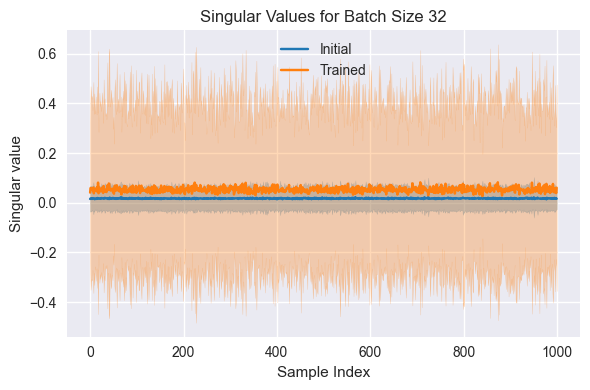

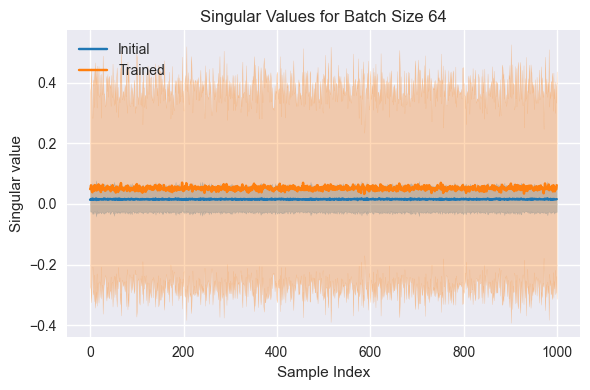

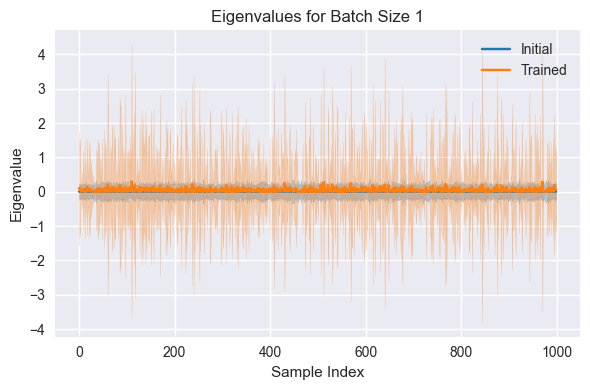

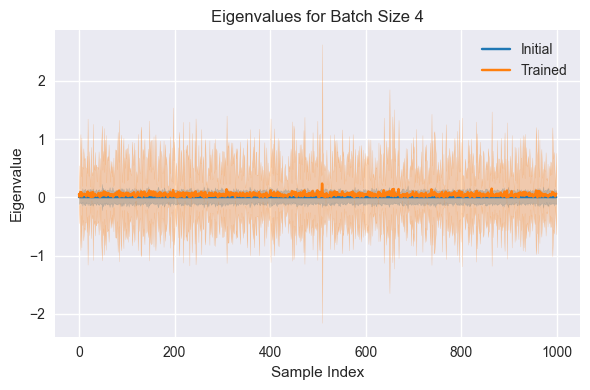

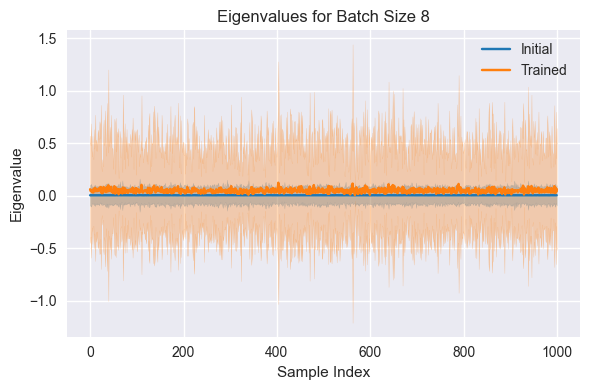

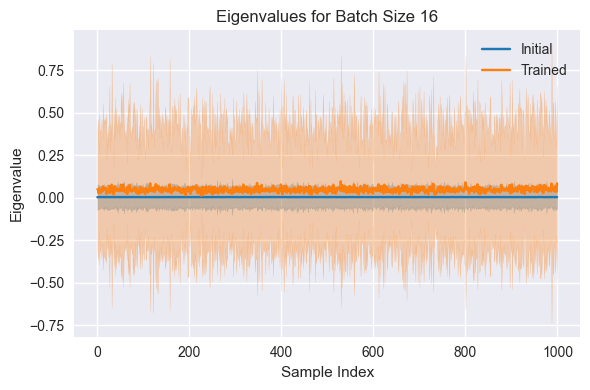

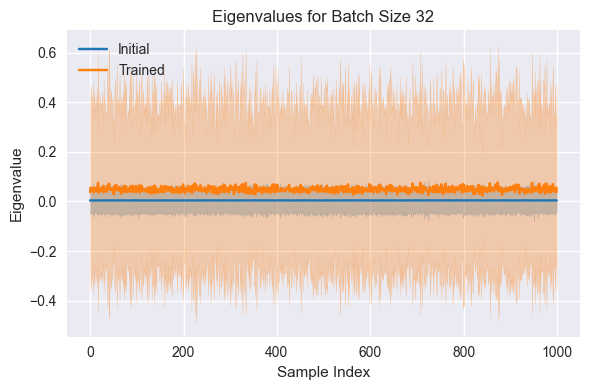

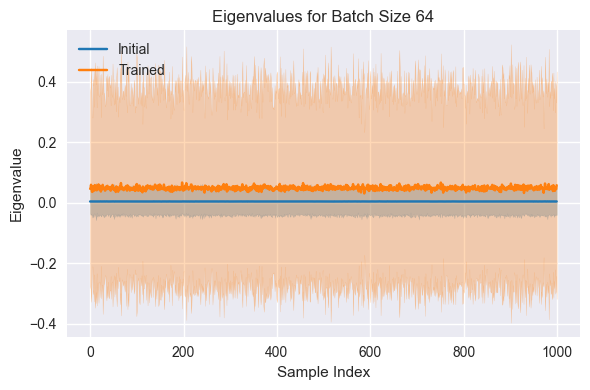

In [7]:

def plot_mean_std(values_df, title, ylabel, key_mean, key_std, labels=('Initial', 'Trained')):
    fig, ax = plt.subplots(figsize=(6, 4))
    x = np.arange(len(values_df))

    # Plot with fill-between for std
    for label, color, prefix in zip(labels, ['tab:blue', 'tab:orange'], ['init_', 'train_']):
        mean = values_df[f'{prefix}{key_mean}']
        std = values_df[f'{prefix}{key_std}']
        ax.plot(x, mean, label=label, color=color)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(ylabel)
    ax.legend()
    return fig, ax

# %% [markdown]
# ### 5.1 По каждому batch_size — сингулярные значения

# %%
for batch_size in sorted(initial_hessians.keys()):
    init_svd_df = get_singular_stats(initial_hessians[batch_size])
    train_svd_df = get_singular_stats(trained_hessians[batch_size])

    svd_df = pd.DataFrame({
        'init_mean': init_svd_df['mean'],
        'init_std': init_svd_df['std'],
        'train_mean': train_svd_df['mean'],
        'train_std': train_svd_df['std'],
    })

    fig, ax = plot_mean_std(
        svd_df,
        title=f"Singular Values for Batch Size {batch_size}",
        ylabel="Singular value",
        key_mean="mean",
        key_std="std"
    )
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### 5.2 По каждому batch_size — собственные значения

# %%
for batch_size in sorted(initial_hessians.keys()):
    init_eig_df = eigenvalue_fluctuations(initial_hessians[batch_size])
    train_eig_df = eigenvalue_fluctuations(trained_hessians[batch_size])

    eig_df = pd.DataFrame({
        'init_mean': init_eig_df['mean'],
        'init_std': init_eig_df['std'],
        'train_mean': train_eig_df['mean'],
        'train_std': train_eig_df['std'],
    })

    fig, ax = plot_mean_std(
        eig_df,
        title=f"Eigenvalues for Batch Size {batch_size}",
        ylabel="Eigenvalue",
        key_mean="mean",
        key_std="std"
    )
    plt.tight_layout()
    plt.show()


## 3. Коммутатор матриц среднего гессиана и среднего квадрата гессиана

Коммутатор $[A, B] = AB - BA$ показывает, могут ли две матрицы быть одновременно диагонализованы. Если коммутатор равен нулю, значит $A$ и $B$ коммутируют и могут быть диагонализованы одной и той же матрицей. Это важно, так как совпадение собственных направлений у $\mathbb{E}[H]$ и $\mathbb{E}[H^2]$ может говорить об устойчивости направления кривизны и градиента.

Здесь мы считаем норму Фробениуса $\|[H, H^2]\|_F^2$ для разных batch size.


## Коммутатор между средним гессианом и средним квадратом


In [8]:

commutator_norms = []

for batch_size in sorted(initial_hessians.keys()):
    init_Hs = np.stack(initial_hessians[batch_size])
    train_Hs = np.stack(trained_hessians[batch_size])

    H_init = np.mean(init_Hs, axis=0)
    H2_init = np.mean(np.matmul(init_Hs, init_Hs), axis=0)
    comm_init = H_init @ H2_init - H2_init @ H_init
    norm_init = np.linalg.norm(comm_init, ord='fro')**2

    H_train = np.mean(train_Hs, axis=0)
    H2_train = np.mean(np.matmul(train_Hs, train_Hs), axis=0)
    comm_train = H_train @ H2_train - H2_train @ H_train
    norm_train = np.linalg.norm(comm_train, ord='fro')**2

    commutator_norms.append({
        'batch_size': batch_size,
        'comm_init': norm_init,
        'comm_trained': norm_train
    })

comm_df = pd.DataFrame(commutator_norms)


### Визуализация нормы коммутатора

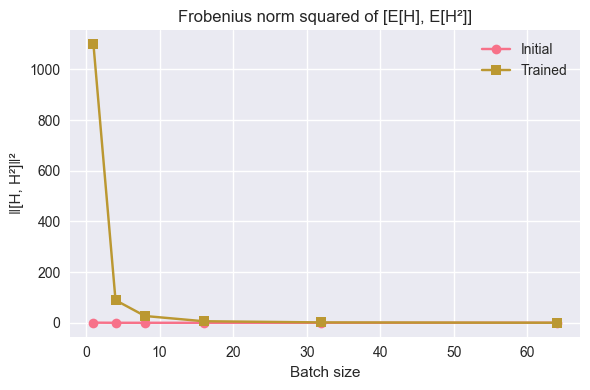

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(comm_df['batch_size'], comm_df['comm_init'], label='Initial', marker='o')
ax.plot(comm_df['batch_size'], comm_df['comm_trained'], label='Trained', marker='s')

ax.set_title('Frobenius norm squared of [E[H], E[H²]]')
ax.set_xlabel('Batch size')
ax.set_ylabel('‖[H, H²]‖²')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


## 4. Анализ флуктуаций собственных значений

Собственные значения гессиана характеризуют локальную кривизну функции потерь. Их флуктуации и наличие отрицательных значений могут указывать на наличие седловых точек и нестабильность оптимизации.

Мы изучим:
- Среднее и стандартное отклонение собственных значений
- Долю отрицательных собственных значений
- Распределение спектра для разных batch size до и после обучения


### Сбор статистик по собственным значениям

In [10]:

# %%
eig_stats = []

for batch_size in sorted(initial_hessians.keys()):
    init_eig = eigenvalue_fluctuations(initial_hessians[batch_size])
    train_eig = eigenvalue_fluctuations(trained_hessians[batch_size])

    eig_stats.append({
        'batch_size': batch_size,
        'init_mean': init_eig['mean'].mean(),
        'train_mean': train_eig['mean'].mean(),
        'init_std': init_eig['std'].mean(),
        'train_std': train_eig['std'].mean(),
        'init_neg_frac': init_eig['num_negative'].sum() / init_eig['total'].sum(),
        'train_neg_frac': train_eig['num_negative'].sum() / train_eig['total'].sum(),
    })

eig_df = pd.DataFrame(eig_stats)


### Графики статистик собственных значений

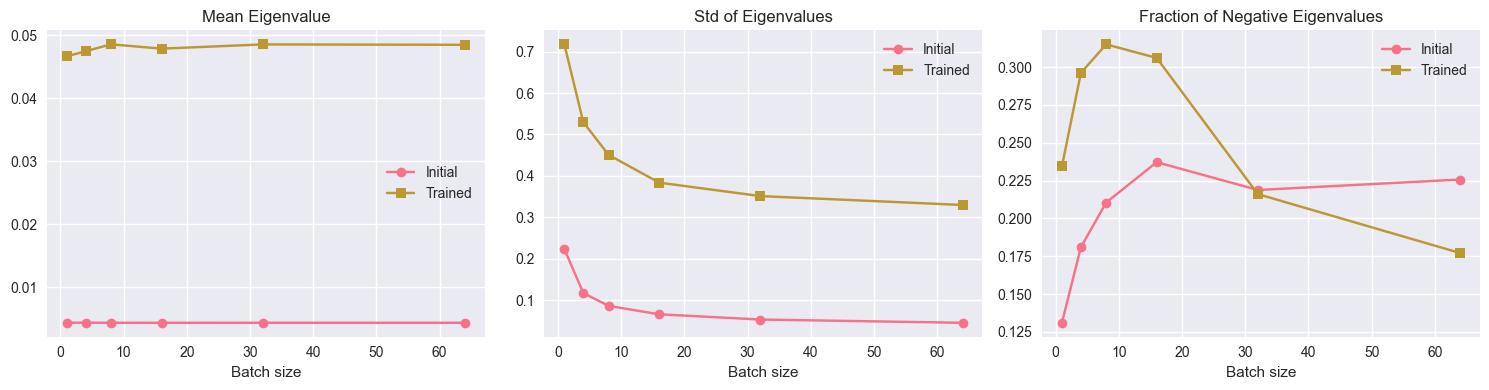

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(eig_df['batch_size'], eig_df['init_mean'], label='Initial', marker='o')
axes[0].plot(eig_df['batch_size'], eig_df['train_mean'], label='Trained', marker='s')
axes[0].set_title('Mean Eigenvalue')
axes[0].set_xlabel('Batch size')
axes[0].grid(True)

axes[1].plot(eig_df['batch_size'], eig_df['init_std'], label='Initial', marker='o')
axes[1].plot(eig_df['batch_size'], eig_df['train_std'], label='Trained', marker='s')
axes[1].set_title('Std of Eigenvalues')
axes[1].set_xlabel('Batch size')
axes[1].grid(True)

axes[2].plot(eig_df['batch_size'], eig_df['init_neg_frac'], label='Initial', marker='o')
axes[2].plot(eig_df['batch_size'], eig_df['train_neg_frac'], label='Trained', marker='s')
axes[2].set_title('Fraction of Negative Eigenvalues')
axes[2].set_xlabel('Batch size')
axes[2].grid(True)

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


## Сингулярные значения в лог-масштабе: среднее и std по индексам


In [ ]:

def get_svd_arrays(hessian_list):
    """Вычисляет SVD и возвращает массив сингулярных чисел: shape (num_iters, dim)"""
    all_s = []
    for H in hessian_list:
        s = svd(H, compute_uv=False)
        all_s.append(s)
    return np.stack(all_s)  # shape: (num_iters, num_params)



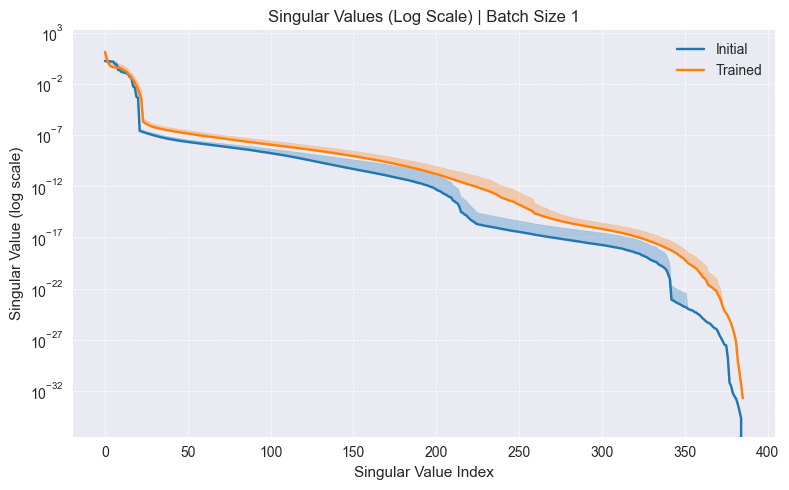

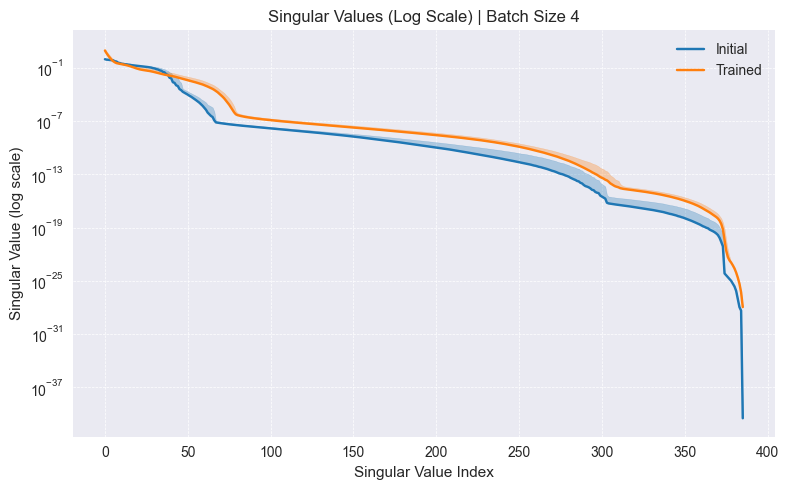

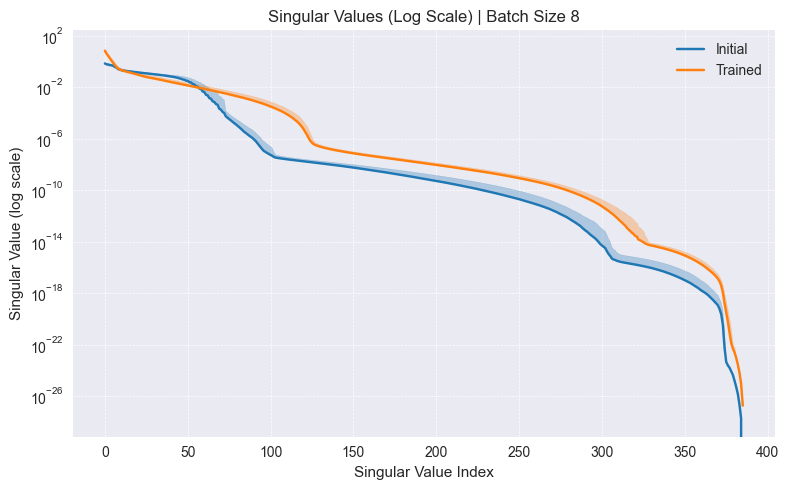

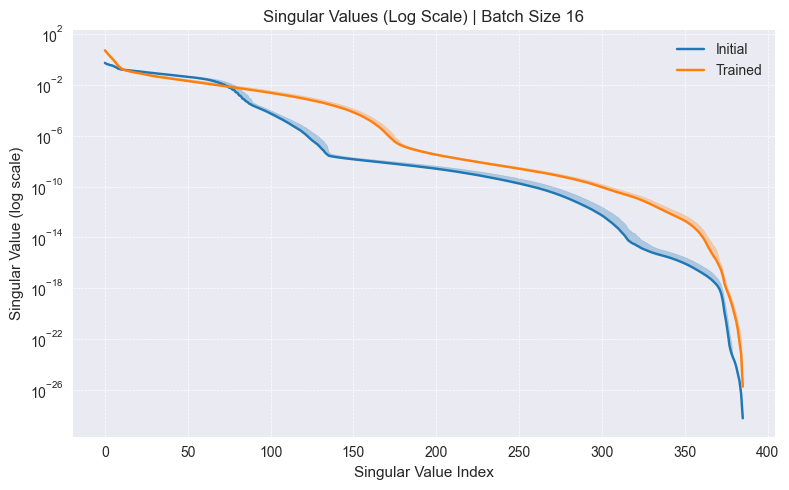

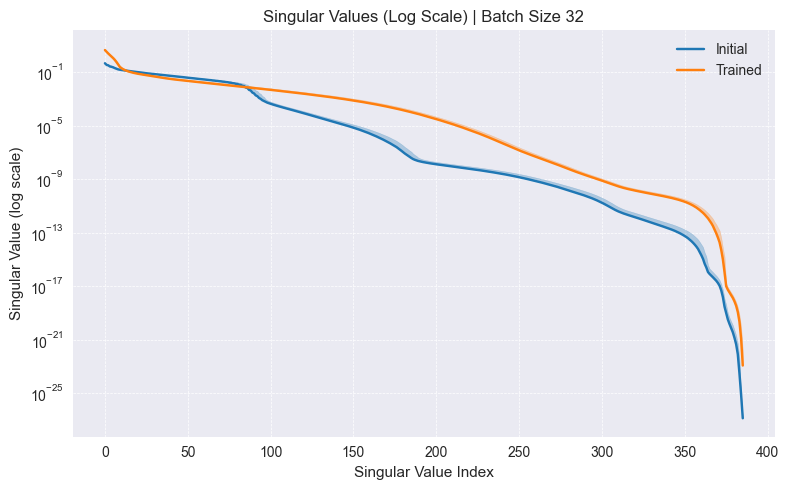

In [ ]:

for batch_size in sorted(initial_hessians.keys()):
    init_svals = get_svd_arrays(initial_hessians[batch_size])
    train_svals = get_svd_arrays(trained_hessians[batch_size])

    mean_init = np.mean(init_svals, axis=0)
    std_init = np.std(init_svals, axis=0)

    mean_train = np.mean(train_svals, axis=0)
    std_train = np.std(train_svals, axis=0)

    x = np.arange(len(mean_init))  # индексы сингулярных чисел

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, mean_init, label="Initial", color="tab:blue")
    ax.fill_between(x, mean_init , mean_init + std_init, alpha=0.3, color="tab:blue")

    ax.plot(x, mean_train, label="Trained", color="tab:orange")
    ax.fill_between(x, mean_train , mean_train + std_train, alpha=0.3, color="tab:orange")

    ax.set_yscale('log')
    ax.set_title(f"Singular Values (Log Scale) | Batch Size {batch_size}")
    ax.set_xlabel("Singular Value Index")
    ax.set_ylabel("Singular Value (log scale)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()
